# Environment Setup

## Installs, Imports, Configurations

In [ ]:
# install libraries not on colab
# %pip install -U --pre efficientnet

# # How to import my custom modules in colab?
# # https://tinyurl.com/y7dfv2l7
# sys.path.append('/content/gdrive/My Drive/melanoma/')
# from utils.fealib import TFRECParser

In [113]:
import tensorflow as tf
import re
import math
import tensorflow.keras as keras
import efficientnet.tfkeras as efn

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall
from tensorflow.train import Feature, Features, Example
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import applications
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential


import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

import os
import sys
from IPython.display import display 
from io import BytesIO
import time
import datetime
import warnings

from PIL import Image
from skimage import io
import logging
import random
from typing import List

# colab online
# PATH_KAGGLE_MEL = '/content/gdrive/My Drive/Kaggle/melanoma/'
# REPO_ROOT = '/content/gdrive/My Drive/melanoma/'
# REPO_TEMP = REPO_ROOT + 'temp/'

# jupyter offline
PATH_KAGGLE_MEL_OFFLINE = './../kaggle_symlink_offline/melanoma/'
PATH_KAGGLE_MEL = PATH_KAGGLE_MEL_OFFLINE
REPO_ROOT = './../../'
REPO_TEMP = REPO_ROOT + 'temp/'

TFREC_DIR = PATH_KAGGLE_MEL + 'tfrecords/triple_stra_{}/'

# suppress warning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)

# mount google drive only on colab
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')

In [119]:
# option: TPU, GPU (default to CPU if the specified processor is not found)
PROCESSOR = "TPU" 

FOLDS = 2 # option: 3, 5, 15 

# https://tinyurl.com/yao4obsb
# A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
# Therefore, for efficient utilization of Cloud TPU, a program should make use of 
# each of the eight cores.
#
# https://tinyurl.com/y99kjyh5
# Model processing performance
# For optimum memory usage, use the largest batch size that will fit in memory. 
# Each TPU core uses a 128 x 128 memory cell matrix for processing. In general, 
# your batch sized should be evenly divisible by 128 to most effectively use the TPU memory.
#
# https://tinyurl.com/yawn2acn
# Batch Size Too Small
# The batch size of any model should always be at least 64 (8 per TPU core) 
# because TPU always pads the tensors to this size. The ideal batch size when 
# training on the TPU is 1024 (128 per TPU core), since this eliminates inefficiencies 
# related to memory transfer and padding.
#
# https://tinyurl.com/y9nojpa2
# Minimal requirement: A multiple of 8!
BATCH_SIZES = [1024] * FOLDS 
EPOCHS = [1] * FOLDS

EFF_NETS = [6] * FOLDS # type(s) of EfficientNet that will be used
IMG_SIZES = [128] * FOLDS
ASSET_DIRS = [None] * FOLDS
for i, k in enumerate(IMG_SIZES):
    ASSET_DIRS[i] = TFREC_DIR.format(k)

# Images used for validation should be subject to the same random augmentation
# mechanism if input images are randomly augmented. TTA specifies the number of 
# times each validation image will be randomly augmented and predicted. A final
# predicted probability is then calculated by averaging.
TTA_STEPS = 1 # TEST TIME AUGMENTATION STEPS
RANDOM_AUG = True

SEED = 42 # used for creating k-fold

## Testing Google Drive Connection

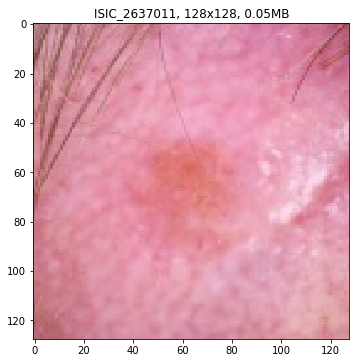

In [120]:
class TFRECParser:
    """Class to parse the TFRecord files that come with the original dataset.
    """
    __TFREC_DESCRIPTOR = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    } 

    def __init__(self) -> None:
        self.__dataset = None # tf.data.TFRecordDataset

    @tf.autograph.experimental.do_not_convert
    def load(self, path_tfrec: str = 'tfrecords/train*.tfrec') -> None:
        def parser(serialized_example: Example) -> Example:
            example = tf.io.parse_single_example(serialized_example,
                                                 features=TFRECParser.__TFREC_DESCRIPTOR)
            return example
        self.__dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(path_tfrec))
        self.__dataset = self.__dataset.map(parser)

    def get_dataset(self) -> tf.data.Dataset:
        return self.__dataset

    def get_image_arr(self, image_name: str) -> np.ndarray:
        record_dataset = self.__dataset.filter(lambda example: tf.equal(example["image_name"], image_name))
        example = next(iter(record_dataset))
        arr = tf.image.decode_jpeg(example['image'], channels=3).numpy()
        return arr

    def get_image(self, image_name: str) -> Image:
        return Image.fromarray(self.get_image_arr(image_name))

    def plot_image(self, image_name: str, figsize: list = [5, 5]) -> Image:
        img_arr = self.get_image_arr(image_name)
        img = Image.fromarray(img_arr)

        # prep title
        title = "{}, {}x{}, {:.2f}MB".format(image_name,
                                             img.size[0],
                                             img.size[1],
                                             sys.getsizeof(img_arr)/1024/1024)

        # render plot
        plt.figure(figsize=figsize)
        io.imshow(img_arr)
        plt.title(title)
        plt.show()

# testing: render a smaple image
parser = TFRECParser()
dir_ = TFREC_DIR.format(IMG_SIZES[0])
parser.load(dir_ + 'train*.tfrec')
parser.plot_image('ISIC_2637011')

## Initializing TPU

In [123]:
if PROCESSOR == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU: ', tpu.master())
    except ValueError:
        print("Error: Unable to connect to TPU...")
        tpu = None

    if tpu:
        try:
            print("Initializing TPU...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized!")
        except _:
            print("Error: Failed to initialize TPU...")
    else:
        PROCESSOR = "GPU"

if PROCESSOR != "TPU":
    print("Using default strategy for CPU/GPU...")
    strategy = tf.distribute.get_strategy()

if PROCESSOR == "GPU":
    print("# of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
            
# https://tinyurl.com/yao4obsb
# A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
# Therefore, for efficient utilization of Cloud TPU, a program should make use of 
# each of the eight cores.
REPLICAS = strategy.num_replicas_in_sync
print(f'# of replicatas in sync: {REPLICAS}')

Using default strategy for CPU/GPU...
# of GPUs Available:  0
REPLICAS: 1


['./../kaggle_symlink_offline/melanoma/tfrecords/triple_stra_128/train00-2182.tfrec'
 './../kaggle_symlink_offline/melanoma/tfrecords/triple_stra_128/train01-2185.tfrec'
 './../kaggle_symlink_offline/melanoma/tfrecords/triple_stra_128/train02-2193.tfrec'
 './../kaggle_symlink_offline/melanoma/tfrecords/triple_stra_128/train03-2182.tfrec'
 './../kaggle_symlink_offline/melanoma/tfrecords/triple_stra_128/train04-2167.tfrec'
 './../kaggle_symlink_offline/melanoma/tfrecords/triple_stra_128/train05-2171.tfrec'
 './../kaggle_symlink_offline/melanoma/tfrecords/triple_stra_128/train06-2175.tfrec'
 './../kaggle_symlink_offline/melanoma/tfrecords/triple_stra_128/train07-2174.tfrec'
 './../kaggle_symlink_offline/melanoma/tfrecords/triple_stra_128/train08-2177.tfrec'
 './../kaggle_symlink_offline/melanoma/tfrecords/triple_stra_128/train09-2178.tfrec'
 './../kaggle_symlink_offline/melanoma/tfrecords/triple_stra_128/train10-2174.tfrec'
 './../kaggle_symlink_offline/melanoma/tfrecords/triple_stra_128/

In [111]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return keras.backend.dot(keras.backend.dot(rotation_matrix, shear_matrix), 
                 keras.backend.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = keras.backend.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = keras.backend.cast(idx2, dtype='int32')
    idx2 = keras.backend.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])


    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_labeled_tfrecord(example) -> tuple:
    """Extract image & label from the tfrecord.
    """
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    """Label is unavailable, extract image & image name from the tfrecord.
    """
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

 
def aug_image(img, augment=True, dim=256):
    """Apply random transformation.
    """
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_examples(file_names: List[str]):
    """Note that the name of each tfrecord file is sufixed with the number of 
    images included.
    """
    n = [int(re.compile(r"-([0-9]*)\.").search(f).group(1)) 
         for f in file_names]
    return np.sum(n)
                  
def get_dataset(tfrec_files: List[str], 
                dim: int,
                batch_size: int = 16,
                augment: bool = False, 
                shuffle: bool = False, 
                repeat: bool = False, 
                labeled: bool = True, 
                return_image_names: bool = True,
                replicas: int = REPLICAS) -> Tuple[tf.data.TFRecordDataset, int]:
    """Return a TFRecordDataset by loading tfrecord files.
    Args:
        tfrec_files (List[str]): List of paths to the tfrecord files.
    Returns:
        [0](TFRecordDataset): Two possible column combinations... 
            - 'image' & 'target' for training dataset
            - 'image' & 'image_name' for test dataset
        [1](int): Number of steps to complete an epoch.
    """
    
    AUTO = tf.data.experimental.AUTOTUNE
    ds = tf.data.TFRecordDataset(tfrec_files, 
                                 num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024 * 8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False # ensure a true random shuffle
        ds = ds.with_options(opt)
    
    if labeled: 
        # extract image & label
        ds = ds.map(read_labeled_tfrecord, 
                    num_parallel_calls=AUTO)
    else:
        # extract image & image name
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, 
                                                            return_image_names), 
                    num_parallel_calls=AUTO)      
    
    # transform image
    ds = ds.map(lambda img, imgname_or_label: (aug_image(img, 
                                                         augment=augment, 
                                                         dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    
    # https://tinyurl.com/yao4obsb
    # A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
    # Therefore, for efficient utilization of Cloud TPU, a program should make use of 
    # each of the eight cores.
    #
    # https://tinyurl.com/y99kjyh5
    # Model processing performance
    # For optimum memory usage, use the largest batch size that will fit in memory. 
    # Each TPU core uses a 128 x 128 memory cell matrix for processing. In general, 
    # your batch sized should be evenly divisible by 128 to most effectively use the TPU memory.
    #
    # https://tinyurl.com/yawn2acn
    # Batch Size Too Small
    # The batch size of any model should always be at least 64 (8 per TPU core) 
    # because TPU always pads the tensors to this size. The ideal batch size when 
    # training on the TPU is 1024 (128 per TPU core), since this eliminates inefficiencies 
    # related to memory transfer and padding.
    #
    # https://tinyurl.com/y9nojpa2
    # Minimal requirement: A multiple of 8!
    n = batch_size
    if PROCESSOR == 'TPU':
        if n // 128 > 0:
            print('Warning: Batch size is not a multiple of 128...')
        if n // 8 > 0:
            print('Warning: Batch size is not a multiple of 8...')
        if n < 64:
            print('Warning: Batch size is smaller than 64...')
    ds = ds.batch(n) 
    
    # From tf doc (https://tinyurl.com/yavczqkr):
    # Most dataset input pipelines should end with a call to prefetch. This allows 
    # later elements to be prepared while the current element is being processed. This 
    # often improves latency and throughput, at the cost of using additional memory to 
    # store prefetched elements.
    ds = ds.prefetch(AUTO)
    
    # steps = <# of examples> / <batch size> / <# of cores>
    steps = count_examples(tfrec_files) / batch_size // 8
    
    return ds, steps

def build_efns(dim: int, 
               ef: int, 
               sig_thd: float = 0.5) -> Sequential:

    EFNS = [efn.EfficientNetB0, 
            efn.EfficientNetB1, 
            efn.EfficientNetB2, 
            efn.EfficientNetB3, 
            efn.EfficientNetB4, 
            efn.EfficientNetB5, 
            efn.EfficientNetB6]
    
    m = Sequential()
    base = efn.EfficientNetB7(weights="imagenet", 
                              include_top=False, 
                              input_shape=(dim, dim, 3))
    m.add(base)
    m.add(GlobalAveragePooling2D())
    m.add(Dense(1, activation="sigmoid"))
    
    # compile model; use accuracy to measure model performance
    o = tf.keras.optimizers.Adam(learning_rate=0.001)
    l = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    metrics = [AUC(),
               BinaryAccuracy(threshold=sig_thd),
               Recall(),]
    m.compile(optimizer=o, loss=l, metrics=metrics)

    return m

In [114]:
BEST_MODEL = True # set true to load the weights from the epoch with the best
                  # performance at the end of training
SAVE_DIR = REPO_ROOT + 'tim/cnn/_saves/cnn_efn/'
TFREC_SPLITS = 2 # count of tfrec files

# create folder for saving best models
save_dir = ''
if BEST_MODEL:
    st = datetime.datetime.fromtimestamp(time.time()).strftime('%m%d_%H_%M_%S')
    save_dir = SAVE_DIR + st
    os.mkdir(save_dir)
    save_dir += '/'

# build k-folds
skf = KFold(n_splits=FOLDS,
            shuffle=True,
            random_state=SEED)
folds = skf.split(np.arange(TFREC_SPLITS)) 

oof_preds = []
oof_targets = []
oof_val = [] # evaluation results
# oof_img_names = []
# oof_folds = [] 
# preds = np.zeros((count_examples(files_test),1))
for fold, (idxT, idxV) in enumerate(folds):
    # print fold info
    print('')
    print('-' * 50); 
    print('FOLD', fold + 1)
    print('Image Size {}, EfficientNetB{}, Batch Size {}'.format(IMG_SIZES[fold],
                                                                 EFF_NETS[fold],
                                                                 BATCH_SIZES[fold] * REPLICAS))
    
    # --------------------------------------------------------------------------
    # BUILD DATASET

    # build train and validation sets from k-fold
    files_train = tf.io.gfile.glob([ASSET_DIRS[fold] + 'train{:0>2d}*.tfrec'.format(x) for x in idxT])
    np.random.shuffle(files_train)
    files_valid = tf.io.gfile.glob([ASSET_DIRS[fold] + 'train{:0>2d}*.tfrec'.format(x) for x in idxV])
    files_test = np.sort(np.array(tf.io.gfile.glob(ASSET_DIRS[fold] + 'test*.tfrec')))
    
    # --------------------------------------------------------------------------
    # BUILD MODEL
    
    # initialize TPU & clear last session
    if PROCESSOR=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    # clear current TF graph to prevent memory leak
    keras.backend.clear_session() 
    # use TPU if possible: https://tinyurl.com/y7pkqrat
    with strategy.scope():
        model = build_efns(dim=IMG_SIZES[fold],
                           ef=EFF_NETS[fold])
    
    # save best model
    callbacks = []
    if BEST_MODEL:
        cb = keras.callbacks.ModelCheckpoint(save_dir + 'best_model_fold_{}.h5'.format(fold), 
                                             monitor='val_loss', 
                                             verbose=1, 
                                             save_best_only=True,
                                             save_weights_only=True, 
                                             mode='min', 
                                             save_freq='epoch')
        callbacks.append(cb)

    # --------------------------------------------------------------------------
    # TRAINING
    
    print('Training...')
    ds_train, steps_train = get_dataset(files_train, 
                                        augment=True, 
                                        shuffle=True, 
                                        repeat=True,
                                        dim=IMG_SIZES[fold], 
                                        batch_size=BATCH_SIZES[fold])
    ds_valid, steps_valid = get_dataset(files_valid,
                                        augment=False,
                                        shuffle=False,
                                        repeat=False,
                                        dim=IMG_SIZES[fold])
    history = model.fit(ds_train, 
                        epochs=EPOCHS[fold], 
                        callbacks=callbacks, 
                        steps_per_epoch=steps_train,
                        validation_data=ds_valid, 
                        #class_weight = {0:1,1:2},
                        verbose=1)

    if BEST_MODEL:
        print('Loading best model...')
        model.load_weights(save_dir + 'best_model_fold_{}.h5'.format(fold))
    
    # --------------------------------------------------------------------------
    # PREDICTIONS
    
    print('Predicting OOF with TTA...')
    # perform TTA
    ds_valid, steps_valid = get_dataset(files_valid,
                                        labeled=False,
                                        return_image_names=False,
                                        augment=True,
                                        repeat=True,
                                        shuffle=False,
                                        dim=IMG_SIZES[fold],
                                        batch_size=BATCH_SIZES[fold])
    steps_valid = TTA_STEPS * steps_valid
    preds = model.predict(ds_valid,
                          steps=steps_valid,
                          verbose=1)
    
    # cut off the "reminders" in the last batch 
    ct_valid = count_examples(files_valid)
    preds = preds[:TTA_STEPS * ct_valid,] 

    # reshape: each column is one round of prediction
    preds_reshape = preds.reshape((ct_valid, TTA_STEPS), order='F')
    preds_avg = np.mean(preds_reshape, axis=1)
    oof_preds.append(preds_avg)                 

    # get oof targets
    ds_valid = get_dataset(files_valid, 
                           augment=False, 
                           repeat=False, 
                           dim=IMG_SIZES[fold],
                           labeled=True, 
                           return_image_names=True)
    targets = [target.numpy() for img, target in iter(ds_valid.unbatch())]
    targets = np.array(targets)
    oof_targets.append(targets)
    # oof_folds.append( np.ones_like(oof_targets[-1], dtype='int8') * fold )

#     # get oof img names
#     ds = get_dataset(files_valid, 
#                      augment=False, 
#                      repeat=False, 
#                      dim=IMG_SIZES[fold],
#                      labeled=False, 
#                      return_image_names=True)
#     img_names = [img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]
#     img_names = np.array(img_names)
#     oof_img_names.append(img_names)
    
    # report oof auc
    auc = roc_auc_score(oof_targets[-1], oof_preds[-1])
    oof_val.append(np.max( history.history['val_auc'] ))
    print('FOLD {}:'.format(fold+1))
    print('OOF AUC without TTA =', oof_val[-1])
    print('OOF AUC with TTA =', auc)
    break
#     # report confusions
#     print(classification_report(Y_hold, preds))

-------------------------
FOLD 1
Image Size 128, EfficientNetB6, Batch Size 32
-------------------------
Training...
 8/68 [==>...........................] - ETA: 10:12 - loss: 0.4819 - auc: 0.3492 - binary_accuracy: 0.8125 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: 